#Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv('1_knn.csv')

In [3]:
df.head()

,Unnamed: 0,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  4998 non-null   int64  
 1   User_ID                     4998 non-null   int64  
 2   Product_ID                  4998 non-null   object 
 3   Gender                      4998 non-null   object 
 4   Age                         4998 non-null   object 
 5   Occupation                  4998 non-null   int64  
 6   City_Category               4998 non-null   object 
 7   Stay_In_Current_City_Years  4998 non-null   object 
 8   Marital_Status              4998 non-null   int64  
 9   Product_Category_1          4998 non-null   int64  
 10  Product_Category_2          3465 non-null   float64
 11  Product_Category_3          1544 non-null   float64
 12  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(6), object(5

In [5]:
df.shape

(4998, 13)

#EDA

1. `Gender` : Female보다 Male이 더 많이 분포함
2. `Age` : 26-35, 36-45, 18-25의 연령층에는 Male이 월등하게 많음

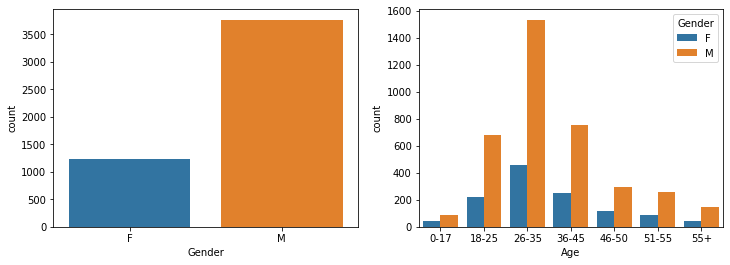

In [6]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
sns.countplot(x="Gender",data=df,ax=ax[0])
sns.countplot(x="Age",hue="Gender",data=df,ax=ax[1])

3. `Purchase`와 `Gender`의 관계에서 female과 male 간의 차이가 두드러진 것을 찾아보기 어려움
4. `Age`와 `Purchase`의 관계에서 특정 연령층과 성별이 가지는 특이점이 없음
5. `Product_Category_1`에서 상품 10이 `Purchase`양이 남여 모두 높음
6. `City_Category`,`Marital_Status`와 `Purchase`의 관계에서 특정 항목이나 성별이 두드러지게 `Purchase`에 기여하는 것을 찾기 어려움

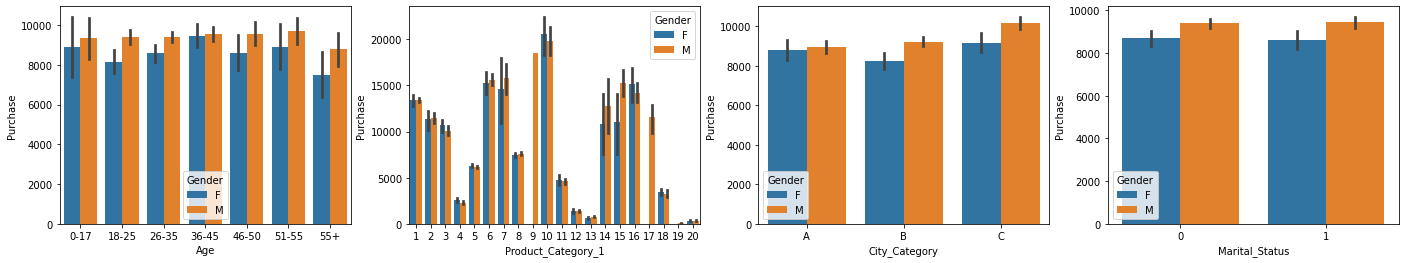

In [7]:

fig, ax = plt.subplots(ncols=4,figsize=(24,4))
sns.barplot(x="Age",y="Purchase",hue="Gender",data=df,ax=ax[0])
sns.barplot(x="Product_Category_1",y="Purchase",hue="Gender",data=df,ax=ax[1])
sns.barplot(x="City_Category",y="Purchase",hue="Gender",data=df,ax=ax[2])
sns.barplot(x="Marital_Status",y="Purchase",hue="Gender",data=df,ax=ax[3])

7. 변수 간의 별다른 선형관계가 존재하지 않음

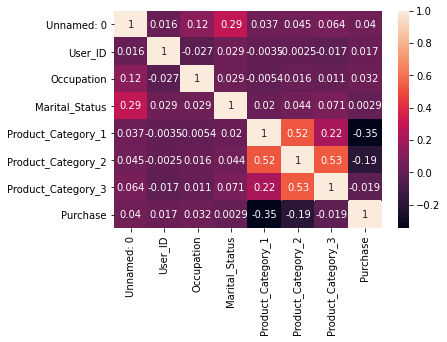

In [8]:
sns.heatmap(df.corr(), annot = True)

#Feature Scaling

##`Unnamed: 0`
인덱스와 동일한 값으로 유의미한 데이터 아님 -> 삭제

In [9]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

##`User_ID`
구매자의 아이디로 이미 모두 개별적인 데이터로 여김 -> 삭제

In [10]:
df["User_ID"].unique()

array([1001088, 1004493, 1005302, ..., 1001176, 1003015, 1000837])

In [11]:
df.drop(["User_ID"],axis=1,inplace=True)

##`Product_Category_2`,`Product_Category_3`
전체 데이터에서 과도하게 결측치 존재함 -> 삭제

In [12]:
#결측지 존재
df.isnull().sum()

Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

In [13]:
#Product_Category_2에는 대략 30%, Product_Category_3에는 대략 70%의 결측지가 존재함
null_value=df.isnull().sum().sort_values(ascending=False)
print("#Percent of null data in features")
print((null_value[null_value>0]/df.shape[0])*100)

#Percent of null data in features
Product_Category_3    69.107643
Product_Category_2    30.672269
dtype: float64


In [14]:
#전제 자료의 최소 1/3이 존재하지 않으므로 삭제
df.drop(["Product_Category_2","Product_Category_3"],axis=1,inplace=True)

##`Product_ID`
판매 상품 번호로 P00~ 형식의 문자열 가짐<br>
P00를 삭제하고 prefix=P로 하여 One-hot Encoding


In [15]:
#Product_ID 값의 분포
df["Product_ID"].value_counts()

P00265242    21
P00220442    16
P00010742    15
P00148642    15
P00151742    15
             ..
P00287442     1
P00283542     1
P00350142     1
P00040842     1
P00365142     1
Name: Product_ID, Length: 1797, dtype: int64

In [16]:
#문자열의 Product_ID 값을 One-hot Encoding을 진행해 품목 당 해당 제품인지 여부를 0과 1표현
df['Product_ID'] = df['Product_ID'].str.replace('P00', '')
df = pd.get_dummies(df, columns=["Product_ID"], prefix = 'P')

##`Gender`
F(female),M(male) 값 가짐<br>
One-hot Encoding: M->1, F->0로 변환

In [17]:
#Gender값 
print(df["Gender"].unique())
#One-hot Encoding : Male여부에 따라 0과 1로 변환
df["Gender"] = df["Gender"].map({'M': 1, 'F':0})

['F' 'M']


##`Age`
연령층(문자열)로 존재하는 `Age`값<br>
0ne-Hot Encoding을 통해 연령층에 해당하지는 여부를 0과 1로 표현


In [18]:
#Age에는 '0-17' '18-25' '26-35' '36-45' '46-50' '51-55' '55+' 존재

print(df["Age"].unique())
df = pd.get_dummies(df, columns=["Age"], prefix = 'Age')

['0-17' '18-25' '26-35' '36-45' '46-50' '51-55' '55+']


##`Occupation`
직업군 별로 10  2  0 19  1  7 12  8  4  9  3 20 15 14 16 17  5  6 11 18 13로 됨<br>
One-hot Encoding을 통해 해당 직업군에 속하는지 여부를 0과 1로 표현

In [19]:
print(df["Occupation"].unique())
df = pd.get_dummies(df, columns=["Occupation"], prefix = 'Ocp')

[10  2  0 19  1  7 12  8  4  9  3 20 15 14 16 17  5  6 11 18 13]


##`City_Category`
도시에 따라 'A',  'B',  'C' 값을 가짐<br>
One-Hot Encoding을 통해 해당 도시인지 여부를 0과 1로 표현

In [20]:

print(df["City_Category"].unique())

df = pd.get_dummies(df, columns=["City_Category"], prefix = 'City')

['A' 'B' 'C']


##`Stay_In_Current_City_Years`
현재 도시에 거주 기간을 '3' '1' '2' '4+' '0'의 문자열로 표현<br>
One-hot Encoding을 통해 해당 기간에 속하는지 여부를 0과 1로 표현

In [21]:
print(df["Stay_In_Current_City_Years"].unique())
df = pd.get_dummies(df, columns=["Stay_In_Current_City_Years"], prefix = 'Stay')

['3' '1' '2' '4+' '0']


##`Marital_Status`
0과 1로 이미 이진 분류 됨

In [22]:
df["Marital_Status"].unique()

array([0, 1])

#**주의**

밑의 주석 처리된 코드 처럼 Encoding이 진행되면 안됨<br><br>
**잘못된 관계를 형성할 수 있음**<br>
예) Age의 경우: '18-25' + '26-35' = '36-45' (1+2=3)

In [23]:
#이렇게 class부여하면 안됨
'''
(1)Age의 경우
df["Age"] = df["Age"].map({'0-17':0, '18-25':1, '26-35':2, '36-45':3, '46-50':4, '51-55':5, '55+':6})

(2)City_Category의 경우
df["City_Category"] = df["City_Category"].map({'A':0 ,'B':1, 'C':2})

(3)Stayed_In_Current_City_Years의 경우
: '0'->0 '1'->1 '2'->2 '3'->3 '4+'->4
def label_stay(year):
  if year=='0':
    return 0
  elif year=='1':
    return 1
  elif year=='2':
    return 2
  elif year=='3':
    return 3
  else:
    return 4
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years'].apply(label_stay)
'''

'\n(1)Age의 경우\ndf["Age"] = df["Age"].map({\'0-17\':0, \'18-25\':1, \'26-35\':2, \'36-45\':3, \'46-50\':4, \'51-55\':5, \'55+\':6})\n\n(2)City_Category의 경우\ndf["City_Category"] = df["City_Category"].map({\'A\':0 ,\'B\':1, \'C\':2})\n\n(3)Stayed_In_Current_City_Years의 경우\n: \'0\'->0 \'1\'->1 \'2\'->2 \'3\'->3 \'4+\'->4\ndef label_stay(year):\n  if year==\'0\':\n    return 0\n  elif year==\'1\':\n    return 1\n  elif year==\'2\':\n    return 2\n  elif year==\'3\':\n    return 3\n  else:\n    return 4\ndf[\'Stay_In_Current_City_Years\'] = df[\'Stay_In_Current_City_Years\'].apply(label_stay)\n'

In [24]:
df

,Gender,Marital_Status,Product_Category_1,Purchase,P_000142,P_000242,P_000342,P_000442,P_000642,P_000742,P_001042,P_001142,P_001242,P_001342,P_001542,P_001642,P_001742,P_001942,P_002042,P_002142,P_002242,P_002342,P_002442,P_002542,P_002742,P_002842,P_002942,P_003242,P_003442,P_003542,P_003642,P_003942,P_004142,P_004242,P_004342,P_004442,P_004542,P_004742,P_004842,P_005042,...,P_99242,P_99342,P_99442,P_99942,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Ocp_0,Ocp_1,Ocp_2,Ocp_3,Ocp_4,Ocp_5,Ocp_6,Ocp_7,Ocp_8,Ocp_9,Ocp_10,Ocp_11,Ocp_12,Ocp_13,Ocp_14,Ocp_15,Ocp_16,Ocp_17,Ocp_18,Ocp_19,Ocp_20,City_A,City_B,City_C,Stay_0,Stay_1,Stay_2,Stay_3,Stay_4+
0,0,0,5,2010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,7,4483,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,0,1,7696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,0,0,2,16429,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0,0,3,5780,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,1,1,1,11701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4994,1,1,8,2045,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4995,1,1,1,4505,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4996,1,1,12,1413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


#Hyperparameter Tuning & Evaluation

In [25]:
#target data 정의
target='Gender'
X = df.drop(target, axis=1)
y = df[target]

##1. KNeighborsClassifier [1]
*   n_neighbors = 3
*   metric ='euclidean'<br>
=> test score : 0.676 (1250개 중 845개 올바르게 분류)


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,random_state=12212)
knn = KNeighborsClassifier(3) 
knn.fit(x_train, y_train)
print('test score : {:.3f}'.format(knn.score(x_test, y_test)))

test score : 0.676


In [27]:
results = knn.predict(x_test)
results

array([1, 1, 1, ..., 1, 1, 1])

In [28]:
pd.crosstab(y_test, results, rownames=['Real'], colnames=['Predicted'], margins=True, margins_name='total')

Predicted,0,1,total
Real,,,
0,42,254,296
1,151,803,954
total,193,1057,1250


In [29]:
from sklearn import metrics
print(metrics.classification_report(y_test,results,target_names=['Male',"Female"], digits=3))

              precision    recall  f1-score   support

        Male      0.218     0.142     0.172       296
      Female      0.760     0.842     0.799       954

    accuracy                          0.676      1250
   macro avg      0.489     0.492     0.485      1250
weighted avg      0.631     0.676     0.650      1250



##2. Finding best K<br>
* k= 1 ~ 29의 accuracy값 그래프
*  10 fold cross-validation

=> k = 29 일 때 accuaracy값이 제일 높음


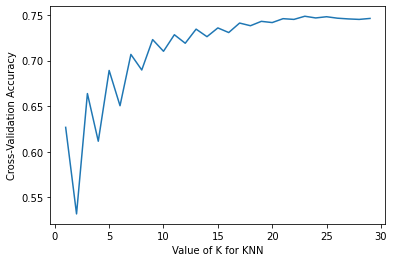

In [30]:
from sklearn.model_selection import cross_val_score
k_range = list(range(1,30))           # k를 1~30지 고려하여 최적의 k찾음
k_score = []                        # 각 k들의 성능 저장하는 리스트

for k in k_range :
    knn = KNeighborsClassifier(k)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring = "accuracy")   
    k_score.append(scores.mean())                   

plt.plot(k_range, k_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validation Accuracy')
plt.show()

## 3. KNeighborsClassifier[2]


*   n_neighbors = 15 
*  metric ='euclidean'<br>
=> test score : 0.760 (1205개 중 950개 올바르게 분류)


In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=12212)
knn = KNeighborsClassifier(29) 
knn.fit(x_train, y_train)
print('test score : {:.3f}'.format(knn.score(x_test, y_test)))

test score : 0.760


In [32]:
results = knn.predict(x_test)
results

array([1, 1, 1, ..., 1, 1, 1])

In [33]:
pd.crosstab(y_test, results, rownames=['Real'], colnames=['Predicted'], margins=True, margins_name='total')

Predicted,0,1,total
Real,,,
0,0,296,296
1,4,950,954
total,4,1246,1250


In [34]:
from sklearn import metrics
print(metrics.classification_report(y_test,results,target_names=['Male',"Female"], digits=3))

              precision    recall  f1-score   support

        Male      0.000     0.000     0.000       296
      Female      0.762     0.996     0.864       954

    accuracy                          0.760      1250
   macro avg      0.381     0.498     0.432      1250
weighted avg      0.582     0.760     0.659      1250



## 4. Finding best n_neigbors & p

In [35]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#조정해 볼 Hyperparameters 리스트 
n_neighbors = list(range(1,30))
p=[1,2]
#해당 Hyperparmeters를 딕셔너리 형태로 바꿔 전달 
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
cv=KFold(n_splits=10, random_state=42)

#KNN
knn = KNeighborsClassifier(29)
clf = GridSearchCV(knn, hyperparameters, cv=cv,scoring='accuracy')
best_model = clf.fit(x_train,y_train)
#GridSearchCV를 통해 최적의 Hyperparameters 값 찾기
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
#test dataset에 적용
y_pred = best_model.predict(x_test)
#accuaracy로 성능평가
print(accuracy_score(y_test, y_pred))
#ROC로 성능 평가
roc_auc_score(y_test, y_pred)

Best p: 2
Best n_neighbors: 25
0.756


0.4964480990424387

#Random Oversampling이용
* 적은 female 자료의 갯수로 인해 oversample 처리하여 데이터 가공
* 불균형한 자료임으로 RepeatedStratifiedKFold 진행

In [37]:
#적은 여성의 분포의 random oversampling
from numpy import mean
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# summarize class distribution
print("y: ",Counter(y))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print("y over: ",Counter(y_over))
# define pipeline
steps = [('over', RandomOverSampler()), ('model', KNeighborsClassifier(29))]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

y:  Counter({1: 3765, 0: 1233})
y over:  Counter({0: 3765, 1: 3765})
F1 Score: 0.535
